# 프로젝트: 폐렴 진단기 성능개선

## Step 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 50

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
COUNT_TOTAL = len(train_filenames)
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
assert COUNT_TOTAL == COUNT_NORMAL + COUNT_PNEUMONIA

print(f"Total images count in training set: {COUNT_TOTAL}")
print(f"Normal images count in training set: {COUNT_NORMAL}")
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")
print(f"Normal vs Pneeumonia ratio: {(COUNT_NORMAL / COUNT_TOTAL):.2f} vs {(COUNT_PNEUMONIA / COUNT_TOTAL):2f}")

Total images count in training set: 5216
Normal images count in training set: 1341
Pneumonia images count in training set: 3875
Normal vs Pneeumonia ratio: 0.26 vs 0.742906


- train data에서 정상 대 폐렴의 비율은 약 1:3
- train data에서 validation에 쓸 데이터를 가져올 때 이 비율을 유지해야 한다.
- validation data의 개수가 train data에 비해 훨씬 작으므로, train data에서 validation data로 사용할 데이터를 정할 때 이 데이터 내부의 정상 대 폐렴 비율을 1:3으로 맞춰주면 충분하다.

In [5]:
# train 데이터에서 라벨 데이터 분포 유지하면서 validation에 쓸 데이터 가져오기 

filenames = tf.io.gfile.glob(TRAIN_PATH)
index_normal, index_pneu = list(), list()

for index, filename in enumerate(filenames):
    if 'NORMAL' in filename:
        index_normal.append(index)
    else:
        index_pneu.append(index)

train_size = int(len(filenames)*0.8)
train_normal_size = int(train_size * 0.25)
train_pneu_size = train_size - train_normal_size

index_normal_train = index_normal[:train_normal_size]
index_normal_val = index_normal[train_normal_size:]
index_pneu_train = index_pneu[:train_pneu_size]
index_pneu_val = index_pneu[train_pneu_size:]
print(len(index_normal_train), len(index_normal_val), len(index_pneu_train), len(index_pneu_val))

train_filenames = list()
for i in index_normal_train:
    train_filenames.append(filenames[i])
for i in index_pneu_train:
    train_filenames.append(filenames[i])
for i in index_normal_val:
    val_filenames.append(filenames[i])
for i in index_pneu_val:
    val_filenames.append(filenames[i])
    
random.shuffle(train_filenames)
random.shuffle(val_filenames)

print(len(train_filenames))
print(len(val_filenames))

1043 298 3129 746
4172
1060


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4172
Validating images count: 1060


In [8]:
# 라벨 데이터 생성

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 이미지 형식 변환
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 경로로부터 이미지 파일 읽어오기
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
# 훈련, 검증 데이터셋
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
# 테스트 데이터셋
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [12]:
# 데이터 augmentation

def random_flip(image,label):   # 랜덤하게 좌우 반전
    image = tf.image.random_flip_left_right(image)  
    return image,label

def random_crop(image, label):  # 랜덤하게 이미지 크롭 후 리사이즈
    image = tf.image.random_crop(image, size=[int(IMAGE_SIZE[0]*0.9), int(IMAGE_SIZE[1]*0.9), 3])
    image = tf.image.resize(image, IMAGE_SIZE)
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(random_flip, num_parallel_calls=2)
    ds = ds.map(random_crop, num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


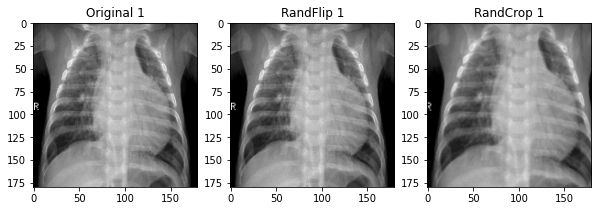

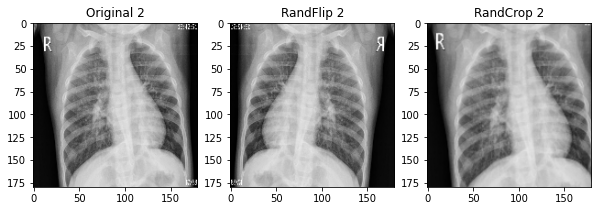

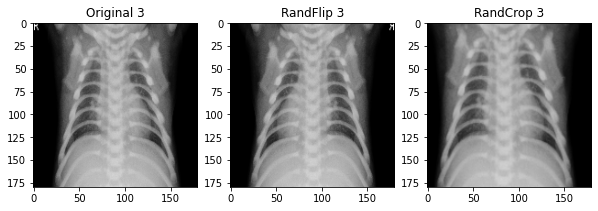

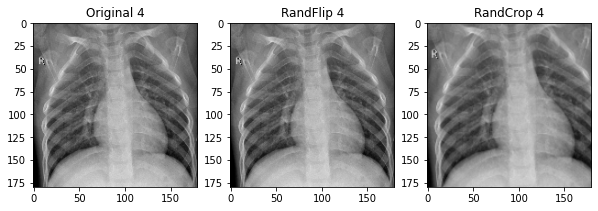

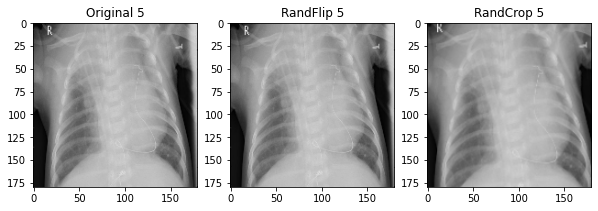

In [13]:
# augmentation 시각화

for i, (image, label) in enumerate(train_ds.take(5)):
    plt.figure(figsize=(10,20))
    plt.subplot(5,3,3*i+1)
    plt.imshow(image)
    plt.title(f'Original {i+1}')
    plt.subplot(5,3,3*i+2)
    plt.imshow(random_flip(image, label)[0])
    plt.title(f'RandFlip {i+1}')
    plt.subplot(5,3,3*i+3)
    plt.imshow(random_crop(image, label)[0])
    plt.title(f'RandCrop {i+1}')

In [14]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [15]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (16, 180, 180, 3)
Label:  [False  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True]


## Step 3. 데이터 시각화

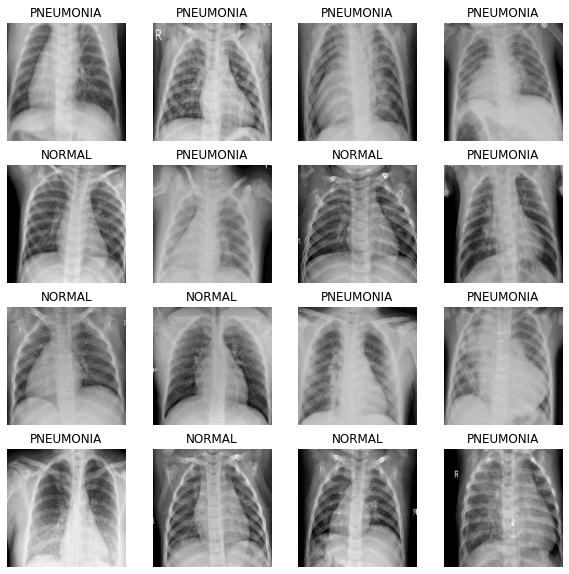

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. ResNet-18 구현

In [17]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, BatchNormalization, Activation, Add
from tensorflow.keras.models import Model

def residual_block(X, filters):
    # Shortcut 연결
    X_shortcut = X
    
    # 첫 번째 컴포넌트
    X = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    
    # 두 번째 컴포넌트
    X = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=-1)(X)
    
    # Shortcut 연결과 결과를 더함
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet18(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)):
    # 입력 텐서 생성
    X_input = Input(input_shape)
    
    # conv1
    X = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    
    # conv2_x
    X = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(X)
    X = residual_block(X, 64)
    X = residual_block(X, 64)
    
    # conv3_x
    X = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(X)  # stride 2로 다운샘플링
    X = residual_block(X, 128)
    X = residual_block(X, 128)
    
    # conv4_x
    X = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(X)  # stride 2로 다운샘플링
    X = residual_block(X, 256)
    X = residual_block(X, 256)
    
    # conv5_x
    X = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(X)  # stride 2로 다운샘플링
    X = residual_block(X, 512)
    X = residual_block(X, 512)
    
    # Average Pooling
    X = AveragePooling2D(pool_size=(5, 5))(X)
    X = Flatten()(X)
    
    # Fully Connected Layer
    X = Dense(1, activation='sigmoid')(X)
    
    # 모델 생성
    model = Model(inputs=X_input, outputs=X, name='ResNet18')
    
    return model

# ResNet-18 모델 생성
model = ResNet18()
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 90, 90, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 90, 90, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

## Step 5. 데이터 imbalance 처리

In [18]:
# class imblance 해결을 위해 weight 조절

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.56
Weight for PNEUMONIA: 0.54


## Step 6. 모델 훈련

In [19]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [20]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
260/260 [==============================] - 67s 203ms/step - loss: 0.3479 - accuracy: 0.8651 - precision: 0.9504 - recall: 0.8656 - val_loss: 4.7745 - val_accuracy: 0.7112 - val_precision: 0.7112 - val_recall: 1.0000
Epoch 2/50
260/260 [==============================] - 53s 204ms/step - loss: 0.1947 - accuracy: 0.9010 - precision: 0.9675 - recall: 0.8980 - val_loss: 1.3174 - val_accuracy: 0.7244 - val_precision: 0.7210 - val_recall: 1.0000
Epoch 3/50
260/260 [==============================] - 53s 205ms/step - loss: 0.1513 - accuracy: 0.9228 - precision: 0.9745 - recall: 0.9211 - val_loss: 0.1791 - val_accuracy: 0.9366 - val_precision: 0.9296 - val_recall: 0.9854
Epoch 4/50
260/260 [==============================] - 54s 210ms/step - loss: 0.1519 - accuracy: 0.9204 - precision: 0.9725 - recall: 0.9198 - val_loss: 2.1905 - val_accuracy: 0.5672 - val_precision: 0.8447 - val_recall: 0.4787
Epoch 5/50
260/260 [==============================] - 56s 217ms/step - loss: 0.1373 - accura

Epoch 37/50
260/260 [==============================] - 49s 187ms/step - loss: 0.0522 - accuracy: 0.9752 - precision: 0.9925 - recall: 0.9743 - val_loss: 0.2332 - val_accuracy: 0.9167 - val_precision: 0.8952 - val_recall: 1.0000
Epoch 38/50
260/260 [==============================] - 50s 194ms/step - loss: 0.0601 - accuracy: 0.9714 - precision: 0.9905 - recall: 0.9711 - val_loss: 0.0971 - val_accuracy: 0.9602 - val_precision: 0.9876 - val_recall: 0.9561
Epoch 39/50
260/260 [==============================] - 48s 186ms/step - loss: 0.0544 - accuracy: 0.9719 - precision: 0.9915 - recall: 0.9710 - val_loss: 0.3777 - val_accuracy: 0.8750 - val_precision: 0.8507 - val_recall: 1.0000
Epoch 40/50
260/260 [==============================] - 50s 192ms/step - loss: 0.0474 - accuracy: 0.9757 - precision: 0.9928 - recall: 0.9746 - val_loss: 0.1080 - val_accuracy: 0.9602 - val_precision: 0.9574 - val_recall: 0.9880
Epoch 41/50
260/260 [==============================] - 48s 186ms/step - loss: 0.0520 - a

## Step 7. 결과 확인과 시각화

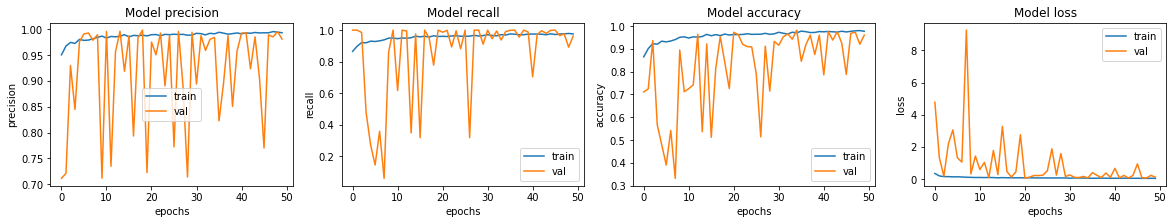

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 117ms/step - loss: 0.5059 - accuracy: 0.8750 - precision: 0.8611 - recall: 0.9538
Loss: 0.505865216255188,
Accuracy: 0.875,
Precision: 0.8611111044883728,
Recall: 0.9538461565971375


- precision, recall, 정확도, 손실 함수의 값이 train 데이터에 대해서는 안정적으로 수렴하는 모습을 보이나 validation data에서는 변동성이 심하다. 과적합이 발생하고 있는 것은 아닐까? dropout layer를 추가하고 L2 정규화 기법을 이용해보자.

In [28]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, BatchNormalization, Activation, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def residual_block(X, filters):
    # Shortcut 연결
    X_shortcut = X
    
    # 첫 번째 컴포넌트 - 정규화 추가
    X = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.01))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    
    # 두 번째 컴포넌트
    X = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.01),)(X)
    X = BatchNormalization(axis=-1)(X)
    
    # Shortcut 연결과 결과를 더함
    X = Add()([X, X_shortcut])
    X = Dropout(0.4)(X)
    X = Activation('relu')(X)
    
    return X

def ResNet18(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)):
    # 입력 텐서 생성
    X_input = Input(input_shape)
    
    # conv1
    X = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    
    # conv2_x
    X = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(X)
    X = residual_block(X, 64)
    X = residual_block(X, 64)
    
    # conv3_x
    X = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(X)  # stride 2로 다운샘플링
    X = residual_block(X, 128)
    X = residual_block(X, 128)
    
    # conv4_x
    X = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(X)  # stride 2로 다운샘플링
    X = residual_block(X, 256)
    X = residual_block(X, 256)
    
    # conv5_x
    X = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(X)  # stride 2로 다운샘플링
    X = residual_block(X, 512)
    X = residual_block(X, 512)
    
    # Average Pooling
    X = AveragePooling2D(pool_size=(5, 5))(X)
    X = Dropout(0.4)(X)
    X = Flatten()(X)
    
    # Fully Connected Layer
    X = Dense(1, activation='sigmoid')(X)
    
    # 모델 생성
    model = Model(inputs=X_input, outputs=X, name='ResNet18')
    
    return model

# ResNet-18 모델 생성
model = ResNet18()
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 90, 90, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 90, 90, 64)   256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 90, 90, 64)   0           batch_normalization_17[0][0]     
___________________________________________________________________________________________

In [29]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [30]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
260/260 [==============================] - 62s 196ms/step - loss: 12.9476 - accuracy: 0.8255 - precision: 0.9410 - recall: 0.8186 - val_loss: 5.3210 - val_accuracy: 0.7112 - val_precision: 0.7112 - val_recall: 1.0000
Epoch 2/50
260/260 [==============================] - 51s 196ms/step - loss: 1.4610 - accuracy: 0.8671 - precision: 0.9531 - recall: 0.8654 - val_loss: 1.7406 - val_accuracy: 0.5057 - val_precision: 0.8904 - val_recall: 0.3467
Epoch 3/50
260/260 [==============================] - 52s 199ms/step - loss: 0.6455 - accuracy: 0.8666 - precision: 0.9511 - recall: 0.8667 - val_loss: 148.7401 - val_accuracy: 0.2907 - val_precision: 1.0000 - val_recall: 0.0027
Epoch 4/50
260/260 [==============================] - 51s 198ms/step - loss: 0.5021 - accuracy: 0.8796 - precision: 0.9577 - recall: 0.8781 - val_loss: 1.7541 - val_accuracy: 0.4290 - val_precision: 0.9934 - val_recall: 0.1995
Epoch 5/50
260/260 [==============================] - 52s 200ms/step - loss: 0.4837 - acc

Epoch 37/50
260/260 [==============================] - 51s 195ms/step - loss: 0.4166 - accuracy: 0.9135 - precision: 0.9751 - recall: 0.9072 - val_loss: 13.0137 - val_accuracy: 0.2907 - val_precision: 1.0000 - val_recall: 0.0027
Epoch 38/50
260/260 [==============================] - 49s 191ms/step - loss: 0.4461 - accuracy: 0.9103 - precision: 0.9725 - recall: 0.9061 - val_loss: 0.8427 - val_accuracy: 0.9167 - val_precision: 0.9438 - val_recall: 0.9387
Epoch 39/50
260/260 [==============================] - 47s 180ms/step - loss: 0.4350 - accuracy: 0.9125 - precision: 0.9713 - recall: 0.9104 - val_loss: 0.4323 - val_accuracy: 0.9100 - val_precision: 0.9781 - val_recall: 0.8935
Epoch 40/50
260/260 [==============================] - 48s 186ms/step - loss: 0.4156 - accuracy: 0.9096 - precision: 0.9734 - recall: 0.9040 - val_loss: 0.4121 - val_accuracy: 0.9195 - val_precision: 0.9023 - val_recall: 0.9947
Epoch 41/50
260/260 [==============================] - 49s 189ms/step - loss: 0.4691 - 

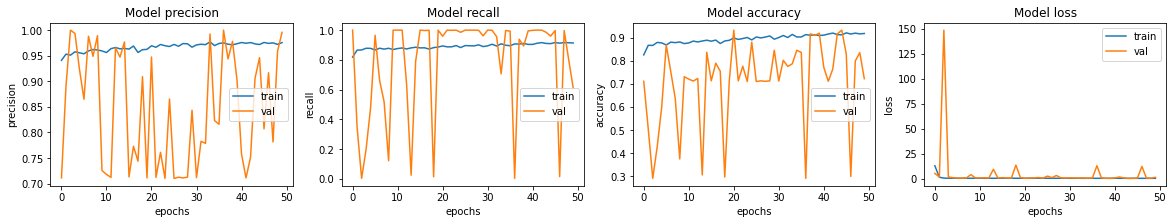

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 약간은 완화되었으나 역시 지표들이 들쭉날쭉한 지점들이 많이 보인다. 이번에는 학습률을 조절해보자.


In [38]:
model = ResNet18()

# 학습률 스케쥴러를 이용해 학습률을 점차 줄여나간다.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2600,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [39]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
260/260 [==============================] - 122s 207ms/step - loss: 9.7923 - accuracy: 0.8142 - precision: 0.9294 - recall: 0.8142 - val_loss: 1.6662 - val_accuracy: 0.7348 - val_precision: 0.7284 - val_recall: 1.0000
Epoch 2/50
260/260 [==============================] - 53s 203ms/step - loss: 0.8584 - accuracy: 0.8733 - precision: 0.9551 - recall: 0.8721 - val_loss: 2.9182 - val_accuracy: 0.3191 - val_precision: 0.9697 - val_recall: 0.0427
Epoch 3/50
260/260 [==============================] - 56s 217ms/step - loss: 0.5532 - accuracy: 0.8772 - precision: 0.9615 - recall: 0.8712 - val_loss: 1.0017 - val_accuracy: 0.7150 - val_precision: 0.7136 - val_recall: 1.0000
Epoch 4/50
260/260 [==============================] - 54s 207ms/step - loss: 0.5292 - accuracy: 0.8757 - precision: 0.9542 - recall: 0.8762 - val_loss: 0.8160 - val_accuracy: 0.7282 - val_precision: 0.7235 - val_recall: 1.0000
Epoch 5/50
260/260 [==============================] - 54s 209ms/step - loss: 0.5199 - accur

260/260 [==============================] - 48s 183ms/step - loss: 0.4568 - accuracy: 0.8950 - precision: 0.9709 - recall: 0.8866 - val_loss: 1.6310 - val_accuracy: 0.7102 - val_precision: 0.7102 - val_recall: 1.0000
Epoch 37/50
260/260 [==============================] - 49s 187ms/step - loss: 0.3977 - accuracy: 0.9156 - precision: 0.9730 - recall: 0.9128 - val_loss: 0.7333 - val_accuracy: 0.7860 - val_precision: 0.7684 - val_recall: 1.0000
Epoch 38/50
260/260 [==============================] - 49s 188ms/step - loss: 0.4525 - accuracy: 0.9113 - precision: 0.9717 - recall: 0.9087 - val_loss: 0.3973 - val_accuracy: 0.9233 - val_precision: 0.9316 - val_recall: 0.9627
Epoch 39/50
260/260 [==============================] - 49s 188ms/step - loss: 0.4403 - accuracy: 0.9106 - precision: 0.9719 - recall: 0.9072 - val_loss: 0.4788 - val_accuracy: 0.8958 - val_precision: 0.9508 - val_recall: 0.9003
Epoch 40/50
260/260 [==============================] - 49s 189ms/step - loss: 0.3941 - accuracy: 0.9

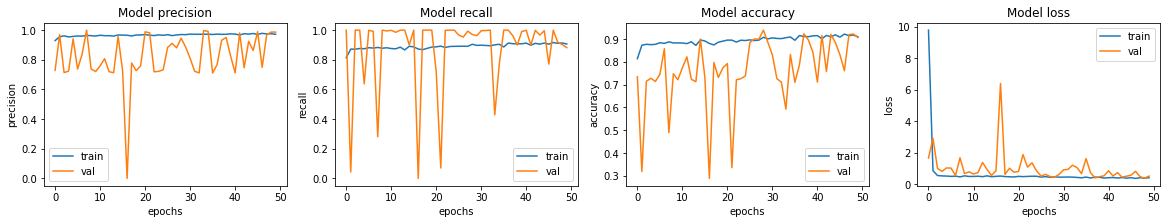

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 이번에도 비교적 안정된 값으로 수렴해가는 loss 함수값을 제외하면 들쭉날쭉한 모양이 유지되고 있다. 그래프를 겹쳐서 그려보자.

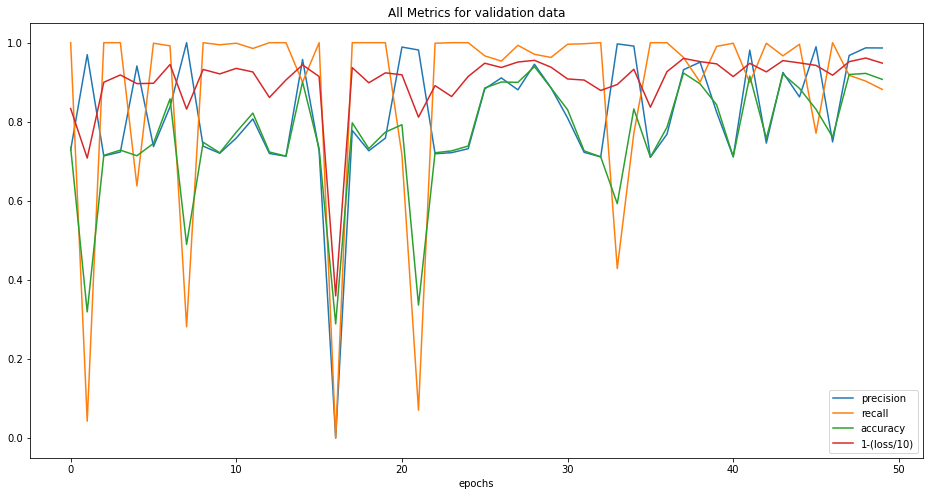

In [56]:
plt.figure(figsize=(16,8))

for i, met in enumerate(['precision', 'recall', 'accuracy']):
    plt.plot(history.history['val_' + met])
plt.plot(list(map(lambda i: 1 - i/10, history.history['val_loss']))) # 비교를 위한 loss 값의 부호 변화 및 스케일링
plt.title('All Metrics for validation data')
plt.xlabel('epochs')
plt.legend(['precision', 'recall', 'accuracy', '1-(loss/10)'])

- 지표들이 안 좋은 성적을 보일 때가 대부분 겹치지만, precision과 recall 사이에는 trade-off가 존재하는 것 같다. 이 둘만 다시 그려보자.

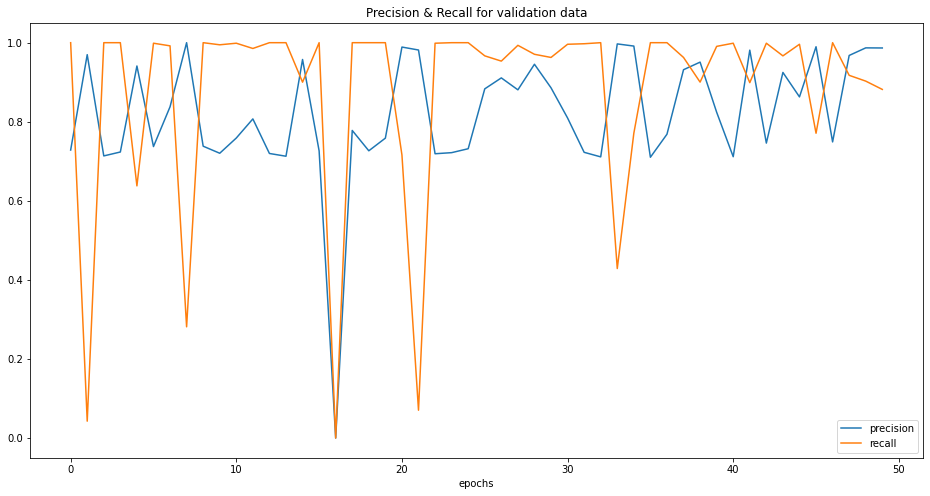

In [57]:
plt.figure(figsize=(16,8))

for i, met in enumerate(['precision', 'recall']):
    plt.plot(history.history['val_' + met])
plt.title('Precision & Recall for validation data')
plt.xlabel('epochs')
plt.legend(['precision', 'recall'])

- 대부분의 피크 지점에서 precision과 recall이 반대로 움직이는 것을 확인할 수 있다. 그렇다면, 둘은 동시에 들쭉날쭉하거나 동시에 안정된 모습을 보이는 경향이 있을 것이다. 

## Step 8. 결론

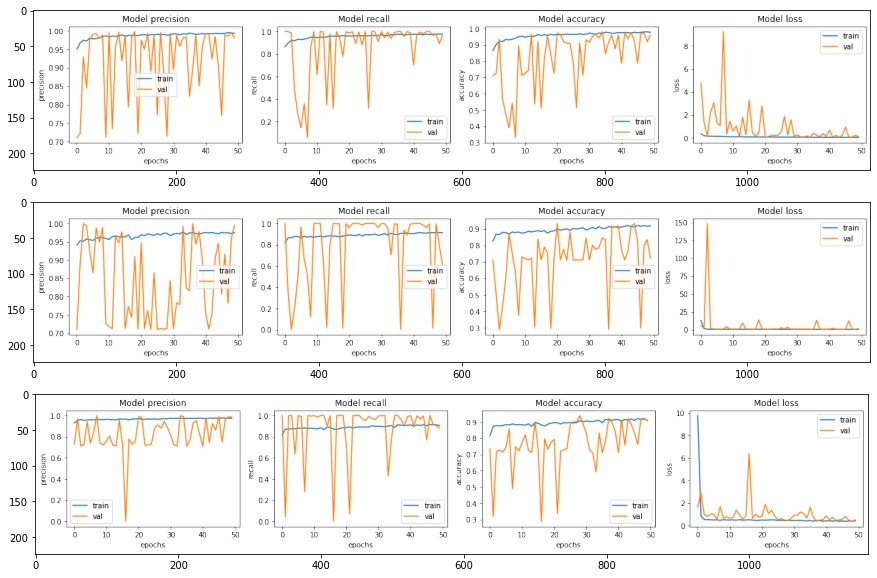

In [61]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax = ax.ravel()
graph1 = plt.imread('graph1.png')
ax[0].imshow(graph1)
graph2 = plt.imread('graph2.png')
ax[1].imshow(graph2)
graph3 = plt.imread('graph3.png')
ax[2].imshow(graph3)
plt.show()

- 훈련 데이터에 대해서는 지표들이 좋은 값을 보인다.
- 실험의 조건을 바꿔가면서 진행했지만, 그래프의 변동성에 확연한 차이는 발생하지 않았다.
- 마지막 실험의 검증 데이터에 대해서 40 에폭 이후부터보면, loss 값은 비교적 안정된 값을 보이며, 나머지 지표 역시 변동은 계속 되지만 이전에 비해 변동 폭이 줄어들고 있다. 만약 에폭 수를 더 늘린다면 좀 더 안정된 결과를 얻을 수 있을 것이라고 기대할 수 있겠다. 이 부분을 직접 확인해보고 싶은데 시간 상의 제약으로 인해 지금 당장은 어려울 것 같다.

## 회고
- ResNet의 구조를 다시 한 번 공부하고 익힐 수 있었다. 다만, ImageNet의 분류 문제를 잘 해결한 모델을 의료 도메인의 이미지 데이터에 대한 이진 분류에 사용하는 것이 적절한지에 대한 의문이 있다. 의료 도메인에서 사용되는 분류 모델을 좀 더 찾아볼 필요가 있겠다.
- 한정된 시간 안에 진행하는 프로젝트인 만큼 학습을 원하는 만큼 더 진행하지 못한 점이 아쉽다. 학습 지표 그래프의 불안정성, 특히 학습 초반부에서 일어나는 큰 변동성에 대한 원인을 잡아내지 못한 것 같아서 아쉽다. 하지만 학습이 진행될 수록 불안정성이 줄어드는 경향을 보이는 것을 확인한 것은 어느 정도의 성과라고 볼 수 있을 것 같다.
- 각 실험마다 데이터를 저장하고 그래프를 다양하게 그렸으면 더 좋았을 것 같다. 아직 실험 결과를 저장하는 법을 잘 모르는데 이 부분을 보완해서 각 실험에서 얻은 데이터끼리 비교하는 작업을 다시 수행해보고 싶다.